In [1]:
import pandas as pd
import numpy as np
import sys
import os
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from simpledbf import Dbf5
import geopandas as gpd

ITERATION = 1
MODEL_FOLDER = r'E:\Met_Council\metc-asim-model\Base_2022\highway'

TAZ_SHAPE = r'E:\Met_Council\metc-asim-model\Input_2022\Visualizer\SHP\TAZ2010.shp'

LAND_USE_INPUT = r'E:\Met_Council\metc-asim-model\Input_2022\socioeconomic'

land_use = pd.read_csv(os.path.join(LAND_USE_INPUT, 'land_use.csv'))

vmt_county = pd.read_csv(r'E:\Met_Council\metc-asim-model\Input_2022\validation\vmt_by_county.csv').set_index('County')

taz_shape = gpd.read_file(TAZ_SHAPE)
county_shape = taz_shape.dissolve('CO_NAME')

dy_net = gpd.read_file(os.path.join(MODEL_FOLDER, f"HWY_LDNET_{ITERATION}_DY.shp")).rename(columns = {'VOL_TOT_DAI': 'Model'}).set_crs('epsg:3722').sjoin(county_shape)
dy_net['linkcode'] = dy_net['A'].astype(str) + "-" + dy_net['B'].astype(str)

counts = pd.read_csv("LinkCounts.csv")
counts = counts[counts['MainlineLink'].str.len() > 1]
counts = counts.merge(dy_net[['linkcode', 'Model', 'DISTANCE']].rename(columns = {'Model': 'Model_mainline'}), how = 'left', left_on = 'MainlineLink', right_on = 'linkcode')
counts = counts.merge(dy_net[['linkcode', 'Model']].rename(columns = {'Model': 'Model_HOT'}), how = 'left', left_on = 'HOTLink', right_on = 'linkcode')
counts['TOT_COUNT'] = counts['HOT_Daily'].fillna(0) + counts['Mainline_Daily'].fillna(0)
counts['TOT_MODEL'] = counts['Model_mainline'].fillna(0) + counts['Model_HOT'].fillna(0)
counts['COUNT_VMT'] = counts['TOT_COUNT'] * counts['DISTANCE']
counts['MODEL_VMT'] = counts['TOT_MODEL'] * counts['DISTANCE']
#dy_net = Dbf5(os.path.join(MODEL_FOLDER, f"HWY_LDNET_{ITERATION}_DAILY.dbf")).to_dataframe().rename(columns = {'COUNT': 'Count', 'VOL_TOT_DAI': 'Model'})

# dy_net['Count_VMT'] = dy_net['Count'] * dy_net['DISTANCE']
dy_net['Model_VMT'] = dy_net['Model'] * dy_net['DISTANCE']



KeyboardInterrupt: 

In [ ]:
pd.DataFrame(counts[counts['TOT_COUNT'] > 0][['COUNT_VMT', 'MODEL_VMT']].sum()).style.format('{:,.0f}')

,0
COUNT_VMT,"11,512,403"
MODEL_VMT,"12,234,866"


In [ ]:
vmt_diff = counts[counts['TOT_COUNT'] > 0]['MODEL_VMT'].sum() - counts[counts['TOT_COUNT'] > 0]['COUNT_VMT'].sum()
pct_diff = vmt_diff / counts[counts['TOT_COUNT'] > 0]['COUNT_VMT'].sum()
print(f"Difference: {vmt_diff:,.0f} ({pct_diff:.2%})")

Difference: 722,463 (6.28%)


In [ ]:
x = counts[counts['TOT_COUNT'] > 0]
print(f"RMSE: {np.sqrt(((x.TOT_MODEL - x.TOT_COUNT)**2).sum() / x.shape[0]) / (x.TOT_COUNT.sum() / (x.TOT_COUNT.count()-1)):.2%}")

RMSE: 64.29%


Slope = 0.8844323850181443, intercept = 93.53780432695157


c:\Users\andrew.rohne\.conda\envs\asim_asr_dev\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


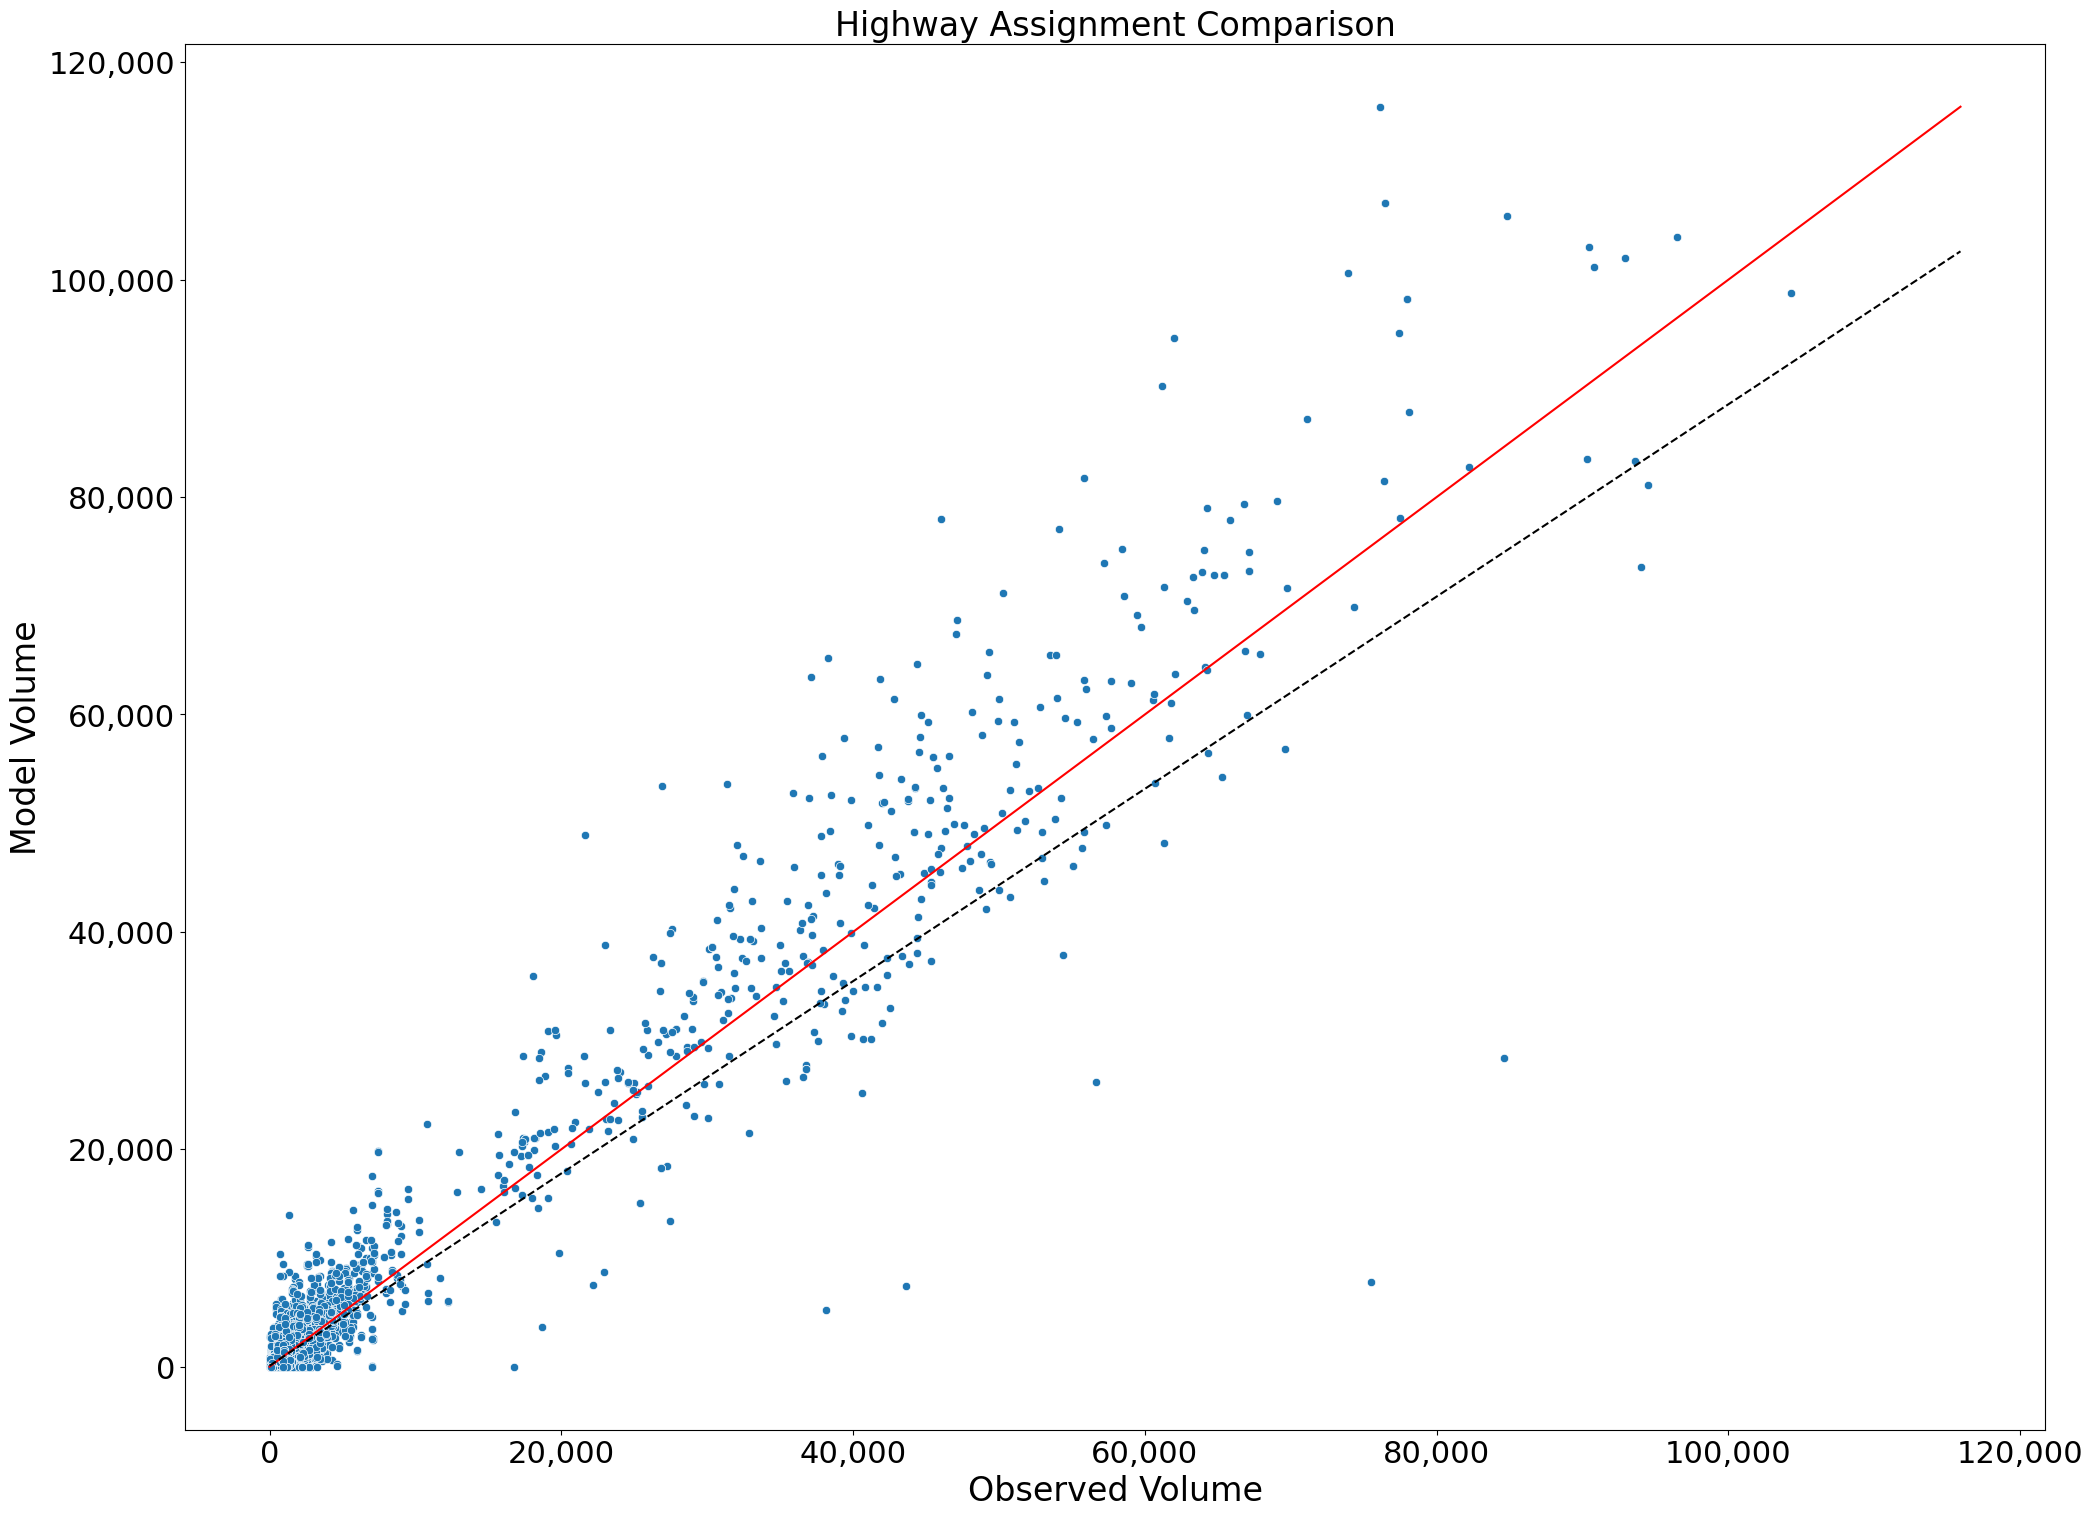

In [ ]:
# counts[counts['TOT_COUNT'] > 0].plot(x = 'TOT_COUNT', y = 'TOT_MODEL', kind = 'scatter')
m,b = np.polyfit(counts[(counts['TOT_COUNT'].fillna(0) > 0)]['TOT_MODEL'], counts[counts['TOT_COUNT'].fillna(0) > 0]['TOT_COUNT'], 1)
poly1d_fn = np.poly1d(np.polyfit(counts[counts['TOT_COUNT'].fillna(0) > 0]['TOT_MODEL'], counts[counts['TOT_COUNT'].fillna(0) > 0]['TOT_COUNT'], 1)) 
print(f"Slope = {m}, intercept = {b}")

ftype_colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'black', 5: 'black', 6: 'black'}

plot_data = counts[counts['TOT_COUNT'] > 0]
x_pred = np.linspace(0, np.max(np.max(plot_data[['TOT_MODEL', 'TOT_COUNT']])), 100)
yy_pred = np.linspace
fig, ax = plt.subplots(figsize=(24, 18))
plot_idx = 111
plt.subplot(plot_idx)
sns.lineplot(x=x_pred, y=x_pred, ax=ax, color = 'red')
sns.lineplot(x = x_pred, y = poly1d_fn(x_pred), ax = ax, color = 'black', linestyle='dashed')
sns.scatterplot(data = plot_data, x = 'TOT_COUNT', y = 'TOT_MODEL') #, c = plot_data['FTYPE'].map(ftype_colors))
plt.title(f"Highway Assignment Comparison", fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Model Volume', fontsize=24)
plt.xlabel('Observed Volume', fontsize=24)
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

In [ ]:
counts[counts['TOT_COUNT'] > 0][['HOTLink', 'MainlineLink', 'TOT_COUNT', 'TOT_MODEL']].to_csv("count_qc.csv")


In [ ]:
vmt_county

,Obs_VMT
County,
Anoka,8.399116e+06
Carver,2.410559e+06
Chisago,2.225375e+06
Dakota,1.083053e+07
Goodhue,1.899308e+06
Hennepin,2.958525e+07
Isanti,1.170623e+06
Le Sueur,7.864032e+05
McLeod,9.897169e+05


In [ ]:
county_shape.index


Index(['Anoka', 'Carver', 'Chisago', 'Dakota', 'Goodhue', 'Hennepin', 'Isanti',
       'Le Sueur', 'McLeod', 'Pierce', 'Polk', 'Ramsey', 'Rice', 'Scott',
       'Sherburne', 'Sibley', 'St. Croix', 'Washington', 'Wright'],
      dtype='object', name='CO_NAME')

<Axes: >

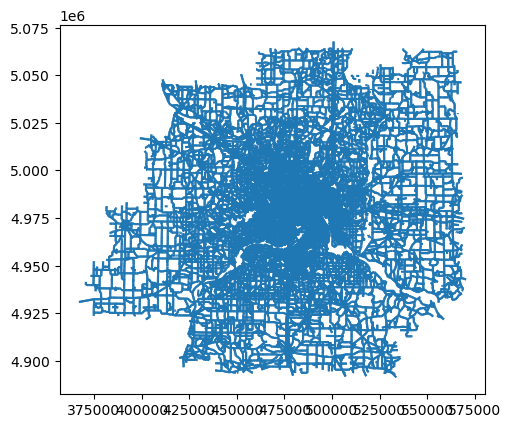

In [ ]:

dy_net.plot()

In [ ]:
taz_shape

,TAZ,CO_NAME,CO_NUM,TAD,CensusTAZ,POPTOTAL,HHTOTAL,HUTOTAL,POPINHH,POPINGQ,...,HHTYPE4,HHTYPE5,HHTYPE6,TOTAL_EMP,RETAIL_EMP,NONRETAIL_,ACRES,Shape_Leng,Shape_Area,geometry
0,1,Anoka,3,1,2.700300e+12,86.0,30.0,32.0,86.0,0.0,...,2.0,3.0,0.0,1.0,0.0,1.0,3488.7359,15327.348373,1.411847e+07,"POLYGON ((460555.993 5028987.573, 460851.077 5..."
1,10,Anoka,3,1,2.700300e+12,225.0,65.0,68.0,225.0,0.0,...,8.0,8.0,1.0,8.0,0.0,8.0,627.5697,6381.066223,2.539695e+06,"POLYGON ((479228.108 5025733.177, 479207.290 5..."
2,100,Anoka,3,4,2.700300e+12,2050.0,684.0,705.0,2044.0,6.0,...,49.0,70.0,16.0,56.0,37.0,19.0,661.8281,6923.134198,2.678334e+06,"POLYGON ((473792.436 5007398.307, 474061.576 5..."
3,1000,Hennepin,53,43,2.705300e+12,685.0,313.0,333.0,681.0,4.0,...,31.0,80.0,73.0,316.0,0.0,316.0,400.2662,5730.898856,1.619827e+06,"POLYGON ((462030.831 4980699.966, 462005.862 4..."
4,1001,Hennepin,53,43,2.705300e+12,1930.0,875.0,958.0,1926.0,4.0,...,126.0,207.0,139.0,315.0,64.0,251.0,518.4721,6981.906532,2.098191e+06,"POLYGON ((461250.313 4982502.500, 461313.601 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3025,2630,Wright,171,27000421,2.717100e+12,1034.0,387.0,439.0,1034.0,0.0,...,49.0,51.0,25.0,29.0,0.0,29.0,22028.2525,43157.536286,8.914553e+07,"POLYGON ((411999.421 4990810.172, 412023.826 4..."
3026,2629,Wright,171,27000421,2.717100e+12,959.0,303.0,344.0,925.0,34.0,...,29.0,46.0,16.0,91.0,0.0,91.0,22743.1226,38565.326434,9.203852e+07,"POLYGON ((405202.644 4990929.459, 405771.926 4..."
3027,2583,Sherburne,141,27000426,2.714100e+12,5963.0,1999.0,2139.0,5947.0,16.0,...,190.0,159.0,71.0,1855.0,235.0,1620.0,5985.8345,21913.767734,2.422391e+07,"POLYGON ((450310.839 5023642.016, 450310.529 5..."
3028,2805,Goodhue,49,27000408,2.704900e+12,386.0,163.0,205.0,386.0,0.0,...,19.0,26.0,14.0,113.0,57.0,56.0,6287.5461,34196.393972,2.544490e+07,"POLYGON ((541820.798 4934877.091, 542250.830 4..."


# Overall Network Summary

In [ ]:
print(f"Total Model VMT: {dy_net['Model_VMT'].sum():,.0f}")

Total Model VMT: 110,620,749


In [ ]:
dy_net[dy_net['Count'] > 0][['Count_VMT', 'Model_VMT']].sum().to_frame().style.format('{:,.0f}')

KeyError: 'Count'

In [ ]:
x = dy_net[dy_net['Count'] > 0]
print(f"{(x.Model-x.Count).mean():,.0f}")

-3,245


In [ ]:
x = dy_net[dy_net['Count'] > 0]
print(f"RMSE: {np.sqrt(((x.Model - x.Count)**2).sum() / x.shape[0]) / (x.Count.sum() / (x.Count.count()-1)):.2%}")

RMSE: 138.50%


In [ ]:
np.corrcoef(dy_net[(dy_net['Count'].fillna(0) > 0)]['Model'], dy_net[(dy_net['Count'].fillna(0) > 0)]['Count'])[0,1]**2

0.8349701288256303

In [ ]:
m,b = np.polyfit(dy_net[(dy_net['Count'].fillna(0) > 0)]['Model'], dy_net[dy_net['Count'].fillna(0) > 0]['Count'], 1)
poly1d_fn = np.poly1d(np.polyfit(dy_net[dy_net['Count'].fillna(0) > 0]['Model'], dy_net[dy_net['Count'].fillna(0) > 0]['Count'], 1)) 
print(f"Slope = {m}, intercept = {b}")

Slope = 1.67066940748301, intercept = 743.4868482734585


c:\Users\andrew.rohne\.conda\envs\asim_asr_dev\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


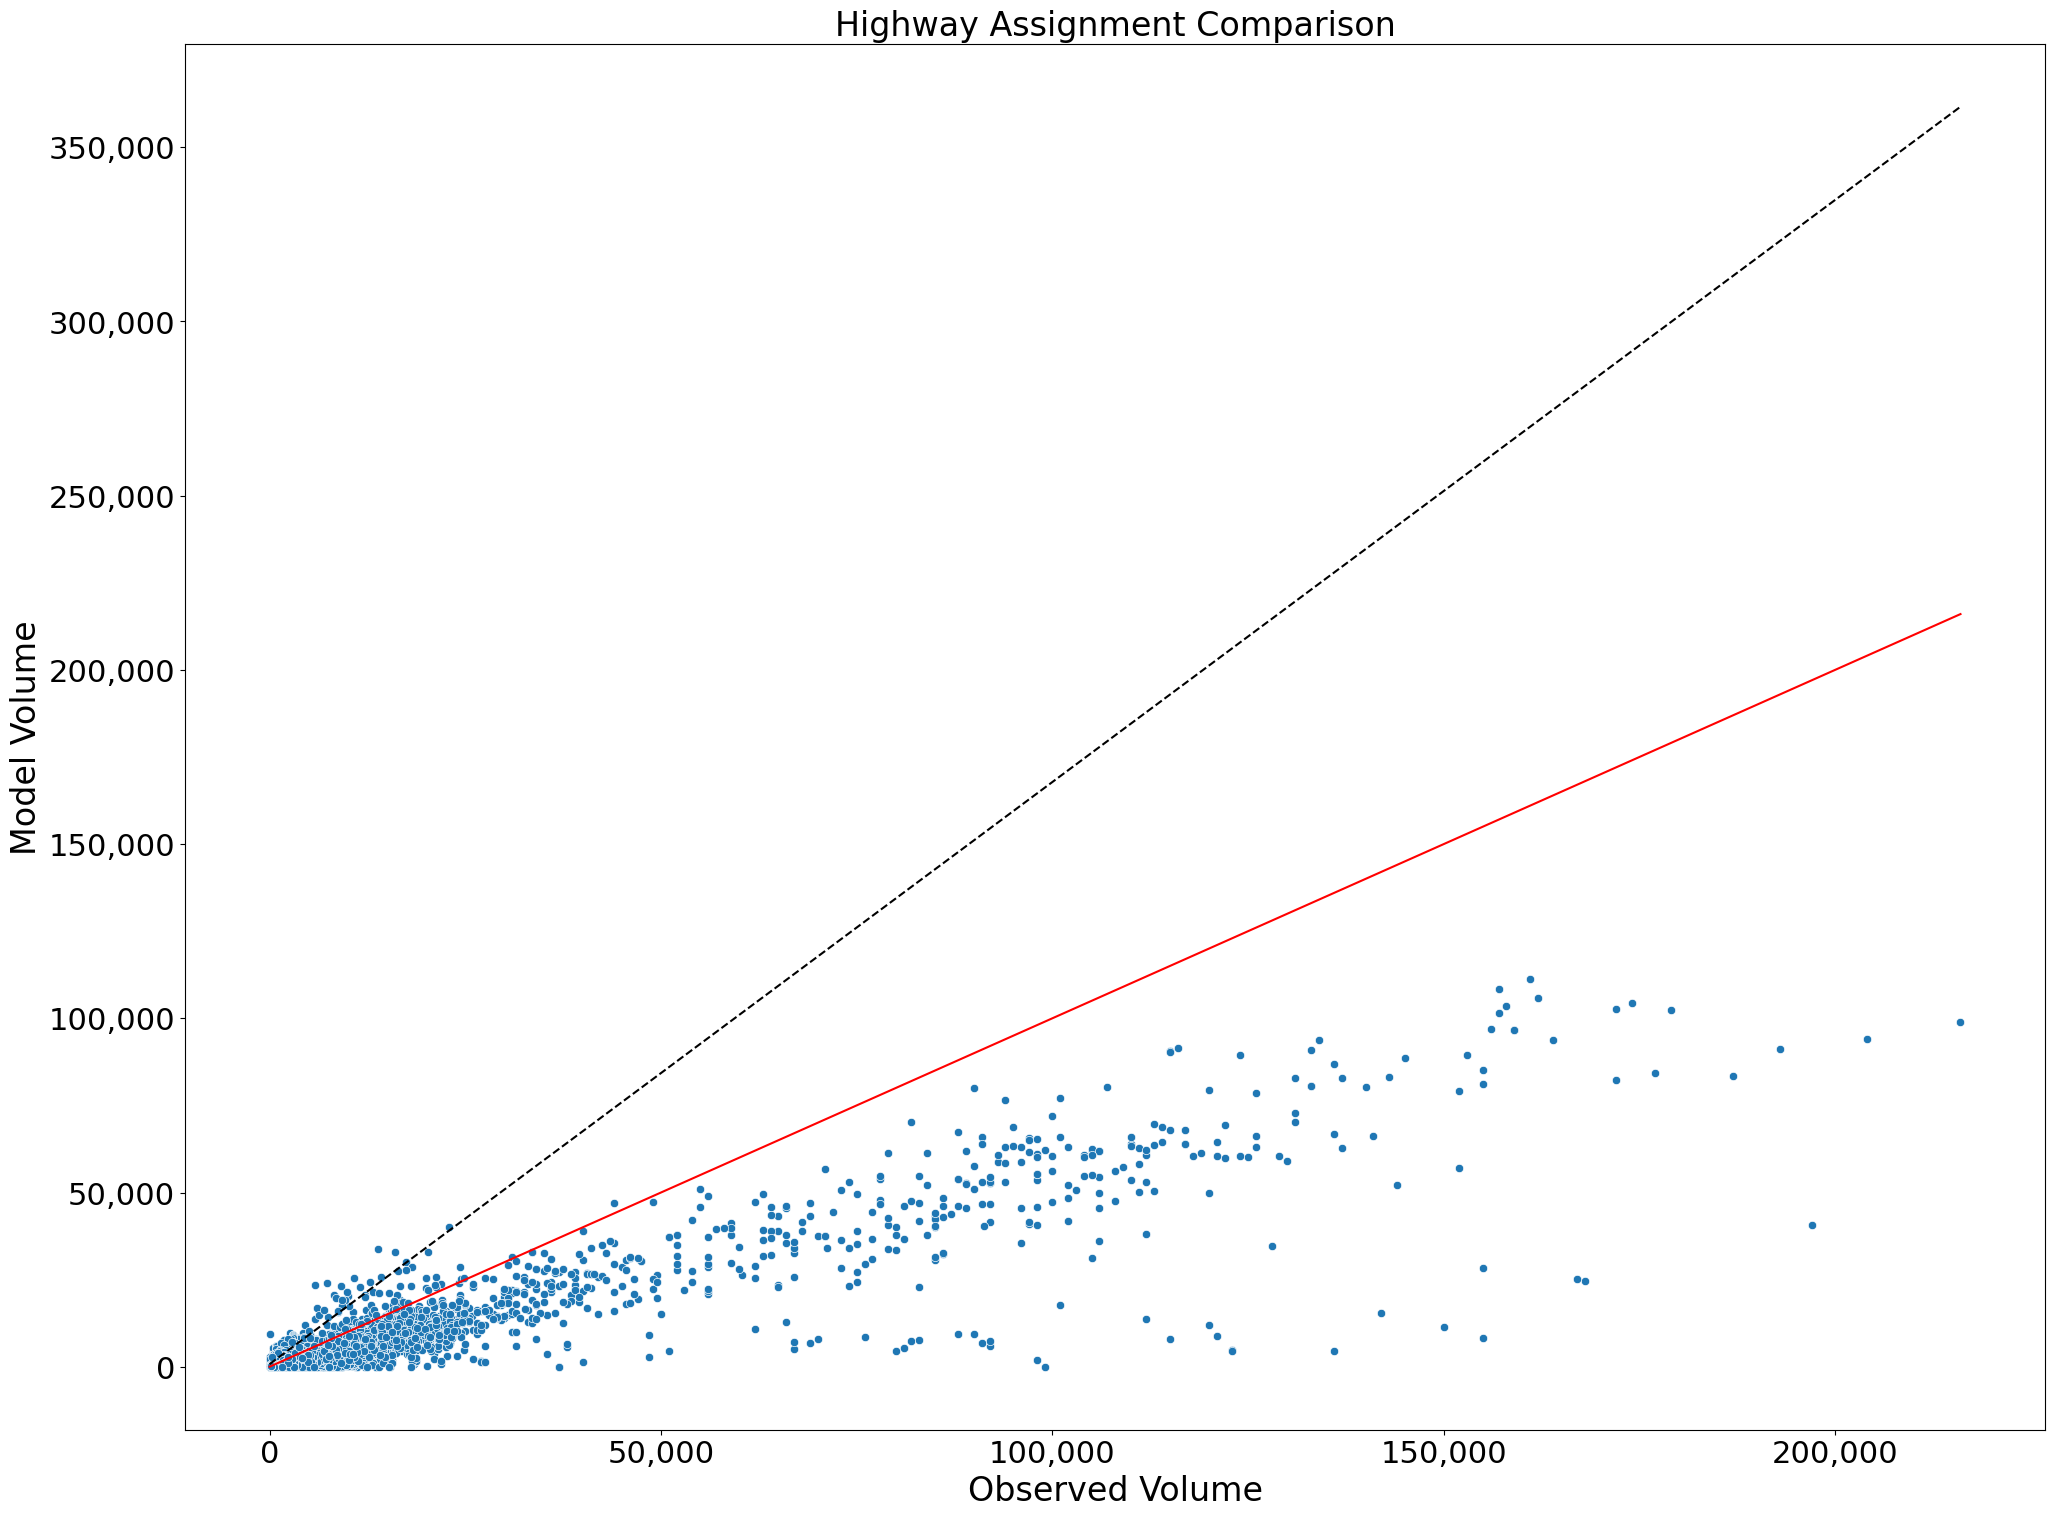

In [ ]:
ftype_colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'black', 5: 'black', 6: 'black'}

plot_data = dy_net[(dy_net['Count'].fillna(0) > 0)]
x_pred = np.linspace(0, np.max(np.max(dy_net[['Model', 'Count']])), 100)
yy_pred = np.linspace
fig, ax = plt.subplots(figsize=(24, 18))
plot_idx = 111
plt.subplot(plot_idx)
sns.lineplot(x=x_pred, y=x_pred, ax=ax, color = 'red')
sns.lineplot(x = x_pred, y = poly1d_fn(x_pred), ax = ax, color = 'black', linestyle='dashed')
sns.scatterplot(data = plot_data, x = 'Count', y = 'Model') #, c = plot_data['FTYPE'].map(ftype_colors))
plt.title(f"Highway Assignment Comparison", fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Model Volume', fontsize=24)
plt.xlabel('Observed Volume', fontsize=24)
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

# HPMS Comparison

In [ ]:
vmt_county['Obs_VMT'].sum()

96226065.131

In [ ]:
hpms_vmt = pd.concat([dy_net.rename(columns = {'index_right': 'County'}).groupby('County').agg(Model_VMT = ('Model_VMT', 'sum')).join(vmt_county),
    pd.DataFrame({'Model_VMT': dy_net['Model_VMT'].sum(), 'Obs_VMT': vmt_county['Obs_VMT'].sum()}, index = ['Total'])])

hpms_vmt['Difference'] = hpms_vmt['Model_VMT'] - hpms_vmt['Obs_VMT']
hpms_vmt['Pct Difference'] = hpms_vmt['Difference'] / hpms_vmt['Obs_VMT']

hpms_vmt.style.format({'Model_VMT': '{:,.0f}', 'Obs_VMT': '{:,.0f}', 'Difference': '{:,.0f}', 'Pct Difference': '{:.2%}'})

,Model_VMT,Obs_VMT,Difference,Pct Difference
Anoka,"8,996,840","8,399,116","597,724",7.12%
Carver,"3,066,571","2,410,559","656,012",27.21%
Chisago,"1,852,971","2,225,375","-372,404",-16.73%
Dakota,"12,121,246","10,830,531","1,290,714",11.92%
Goodhue,"1,977,868","1,899,308","78,561",4.14%
Hennepin,"36,591,468","29,585,245","7,006,223",23.68%
Isanti,"1,121,186","1,170,623","-49,437",-4.22%
Le Sueur,"862,580","786,403","76,176",9.69%
McLeod,"858,224","989,717","-131,493",-13.29%
Pierce,"959,100","1,067,675","-108,575",-10.17%
